In [26]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [27]:
housing = pd.read_csv("AmesHousing.tsv", sep="\t")
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [28]:
def transform_features(train_data):
    nulls = train_data.isnull().sum()
    cutoff = len(train_data)/20
    null_more5 = nulls[nulls > cutoff].index

    #drop more than 5% null columns
    train_data = train_data.drop(null_more5, axis=1)

    #fillna null numeric columns with mode
    numer = train_data.select_dtypes(include = [np.number]).columns
    train_data[numer] = train_data[numer].fillna(train_data[numer].mode().iloc[0])

    #drop remaining null text columns
    remaining_mv = train_data.isnull().sum()[train_data.isnull().sum() > 0]
    train_data = train_data.drop(remaining_mv.index, axis=1)

    train_data["years_until_remod"] = train_data["Year Remod/Add"] - train_data["Year Built"]
    train_data["years_until_sold"] = train_data["Yr Sold"] - train_data["Year Built"]
    train_data = train_data.drop([1702, 2180, 2181], axis=0)
    
    #drop columns irrelevant to learning 
    train_data = train_data.drop(["PID", "Order"], axis=1)

    #drop columns leaking data on sale
    train_data = train_data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Year Remod/Add", "Year Built"], axis=1)
    return train_data

In [29]:
def select_features(data):
    #All features correlation with Saleprice
    corrs = data.corr().abs().loc[:,"SalePrice"].sort_values(ascending=False)

    #Find weak correlated features to drop
    weak_corrs = corrs[corrs < 0.4].index
    data = data.drop(weak_corrs, axis=1)

    qualitatives = list(data.select_dtypes(exclude=[np.number]).columns)
    #qualitatives  = list(text_cols) + ["MS SubClass"]
    cat_count = {}
    highest_freq = {}
    for col in qualitatives:
        data[col] = data[col].astype("category")
        cat_count[col] = len(data[col].value_counts())
        highest_freq[col] = data[col].value_counts(normalize=True)[0]*100

    cat_count = pd.Series(cat_count).sort_values(ascending=False)

    #Find columns with above 95% occurence of a single category to drop
    highest_freq = pd.Series(highest_freq).sort_values(ascending=False)
    above_95 = highest_freq[highest_freq > 95].index
    data = data.drop(above_95, axis=1)
    [qualitatives.remove(x) for x in above_95 if x in qualitatives]

    #Find columns with above 10 categories to drop
    above_10 = cat_count[cat_count > 10].index
    data = data.drop(above_10, axis=1)
    [qualitatives.remove(x) for x in above_10 if x in qualitatives]

    #Non Categorical columns
    non_cate = list(data.columns)
    [non_cate.remove(x) for x in qualitatives if x in non_cate]

    #convert remaining non numeric columns into dummies
    dummies = pd.get_dummies(data[qualitatives], columns=qualitatives)
    data = data.drop(qualitatives, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

In [30]:
def train_and_test(data, k): 
    """Trains dataframe 'data' and uses K-Fold cross validation with 'k' amount of folds.
    data (df): training dataframe.
    k (int): Number of folds.
    
    Returns: RMSE (float) amount.
    """
    numeric_col = data.drop("SalePrice", axis=1).select_dtypes(include=[np.number]).columns
    #numeric_df = data.select_dtypes(include=['integer', 'float'])
    #numeric_col = numeric_df.columns.drop("SalePrice")
    lr = LinearRegression()
    if k == 0:
        train = data[:1460]
        test = data[1460:]
        lr.fit(train[numeric_col], train["SalePrice"])
        pred = lr.predict(test[numeric_col])
        RMSE = mean_squared_error(test["SalePrice"], pred)**0.5
        return RMSE
    
    elif k == 1:
        rand_data = data.iloc[np.random.permutation(len(data))] 
        fold_one = rand_data[:1460]
        fold_two = rand_data[1460:]
        folds = [fold_one, fold_two]
        folds_rmse = []
        for fold in folds:
            train = fold
            test = rand_data.drop(train.index)
            lr.fit(train[numeric_col], train["SalePrice"])
            pred = lr.predict(test[numeric_col])
            RMSE = mean_squared_error(test["SalePrice"], pred)**0.5
            folds_rmse.append(RMSE)
        return sum(folds_rmse)/len(folds_rmse)
    
    elif k > 1:
        from sklearn.model_selection import KFold
        kf = KFold(k, shuffle=True)
        folds_rmse = []
        for train_index, test_index in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            lr.fit(train[numeric_col], train["SalePrice"])
            pred = lr.predict(test[numeric_col])
            RMSE = mean_squared_error(test["SalePrice"], pred)**0.5
            folds_rmse.append(RMSE)
        return sum(folds_rmse)/len(folds_rmse)

In [31]:
transformed = transform_features(housing)
selected = select_features(transformed)

folds_rmse = {}

for i in range(1,11):
    folds_rmse[i] = train_and_test(selected, i)

Text(0.5, 1.0, 'RMSE value to K Folds quantity')

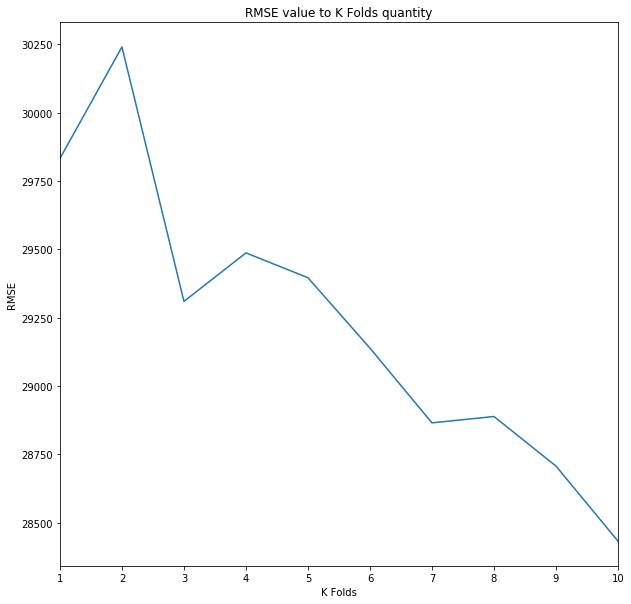

In [32]:
plt.figure(figsize=(10,10))
pd.Series(folds_rmse).plot()
plt.xlabel('K Folds')
plt.ylabel('RMSE')
plt.title("RMSE value to K Folds quantity")

In [45]:
folds_rmse2 = {}

top_corrs = list(selected.corr()['SalePrice'].abs().head().index) + ['SalePrice']

for i in range(1,11):
    folds_rmse2[i] = train_and_test(selected[top_corrs], i)

Text(0.5, 1.0, 'RMSE value to K Folds quantity')

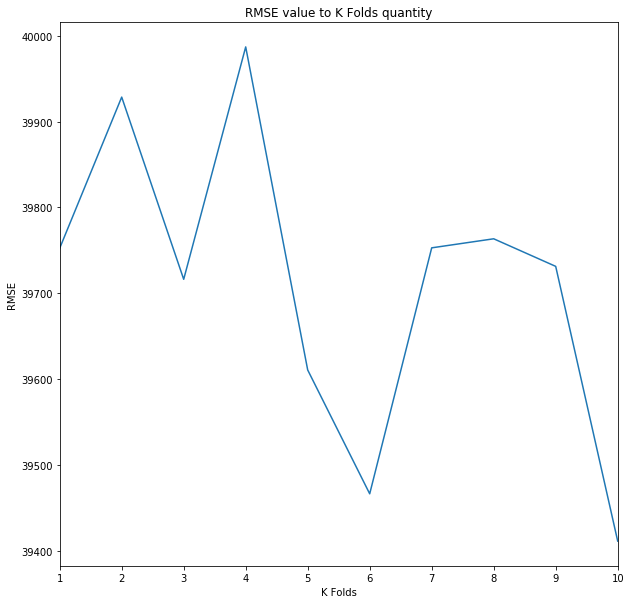

In [46]:
plt.figure(figsize=(10,10))
pd.Series(folds_rmse2).plot()
plt.xlabel('K Folds')
plt.ylabel('RMSE')
plt.title("RMSE value to K Folds quantity")